# Bayesian Mixture Model

A Bayesian mixture model arises when we cannot condition on which component generated each parameter, leaving this membership uncertain and requiring us to treat both the component assignments and parameters as random variables to quantify uncertainty about the underlying heterogeneous structure.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide27.png)

# Key Formula

In a Bayesian mixture model, we cannot observe which component generates each parameter, so we model this uncertainty by assuming the parameter $\beta$ comes from a weighted combination of different distributions:

$$
p(\beta) = \sum_{c=1}^{C} \pi_c p_c(\beta)
$$

where:
- $\pi_c$ represents our uncertainty about which component $c$ the parameter belongs to
- $p_c(\beta)$ is the distribution for that component

This captures heterogeneity by allowing different parameter types while quantifying our uncertainty about which type each parameter represents.

# Technical Details

In statistical genetics, we cannot condition on which type of effect each parameter represents - whether it's null, moderate, or large. This uncertainty about parameter heterogeneity is precisely why we need Bayesian mixture models. Rather than assuming all genetic effects come from a single distribution, we acknowledge that we don't know which "type" each parameter belongs to and model this uncertainty explicitly.

Since we treat parameters as random variables (rather than fixed effects), the mixture model becomes our way of handling the uncertainty about which distribution generated each parameter.

## Component Assignment: Modeling Unknown Group Membership

We cannot observe which component generated our parameter $\beta$, so we introduce a latent variable $z$ to represent this unknown membership:

$$
z \in \{1, 2, \ldots, C\}
$$

Our uncertainty about component membership is captured by:
$$
P(z = c) = \pi_c
$$

Once we condition on the (unknown) component assignment, the parameter follows that component's distribution:
$$
\beta \mid z = c \sim p_c(\beta)
$$

The key insight is that $z$ represents information we cannot condition on directly - we never observe which component actually generated each parameter.

## Prior Structure for Uncertain Components

**Mixture Weights - Quantifying Component Uncertainty**

The mixture weights $\boldsymbol{\pi} = (\pi_1, \pi_2, \ldots, \pi_C)$ represent our prior uncertainty about component frequencies. We place a Dirichlet prior on these weights:

$$
\boldsymbol{\pi} \sim \text{Dirichlet}(\alpha_1, \alpha_2, \ldots, \alpha_C)
$$

This prior quantifies our uncertainty about how common each component is before seeing data.

**Component-Specific Parameters**

Each component represents a different "type" of uncertainty about parameter values. For genetic effects, we might specify:
- Component 1 (null effects): $p_1(\beta) = \mathcal{N}(0, \sigma_1^2)$ with small $\sigma_1^2$
- Component 2 (moderate effects): $p_2(\beta) = \mathcal{N}(0, \sigma_2^2)$ with moderate $\sigma_2^2$  
- Component 3 (large effects): $p_3(\beta) = \mathcal{N}(0, \sigma_3^2)$ with large $\sigma_3^2$

Each $\sigma_c^2$ has its own prior, reflecting our uncertainty about the scale of effects within each component.

Or we can also specify that the mean of each component is different but have a shared variance. Or both of them are different, or even from different distributions even.

## Learning Component Membership from Data

After observing data, we update our uncertainty about which component each parameter belongs to using Bayes' rule:

$$
P(z = c \mid \beta, \text{data}) = \frac{\pi_c p_c(\beta)}{\sum_{j=1}^C \pi_j p_j(\beta)}
$$

This posterior probability quantifies our remaining uncertainty about component membership after conditioning on the observed data. Parameters that fit well with component $c$ receive higher posterior probability for that component.

## Why Mixture Models Handle Conditioning Limitations

- **Acknowledging Unknown Heterogeneity**: We cannot condition on effect type a priori, so mixture models treat this as a source of uncertainty to be quantified rather than ignored.

- **Robust Parameter Estimation**: When we cannot condition on outliers or different parameter types, mixture models prevent extreme values from distorting estimates by assigning them to appropriate components.

- **Flexible Uncertainty Modeling**: We can adapt the mixture structure to reflect different sources of uncertainty - population differences, effect mechanisms, or measurement contexts - by adjusting the components accordingly.

# Related Topics

- [OLS](https://gaow.github.io/statgen-prerequisites/ordinary_least_squares.html)
- [summary statistics](https://gaow.github.io/statgen-prerequisites/summary_statistics.html)
- [random effect](https://gaow.github.io/statgen-prerequisites/random_effect.html)
- [proportion of variance explained and heritability](https://gaow.github.io/statgen-prerequisites/proportion_of_variance_explained.html)
- [likelihood](https://gaow.github.io/statgen-prerequisites/likelihood.html)
- [maximum likelihood estimation](https://gaow.github.io/statgen-prerequisites/maximum_likelihood_estimation.html)
- [Bayesian normal mean model](https://gaow.github.io/statgen-prerequisites/Bayesian_normal_mean_model.html#)
- [Bayesian multivariate normal mean model](https://gaow.github.io/statgen-prerequisites/Bayesian_multivariate_normal_mean_model.html#)

# Example

Remember when we studied how a single genetic variant affects height and weight using the Bayesian multivariate normal mean model? We assumed there *was* an effect and focused on estimating it - figuring out the correlation between height and weight effects for that one variant.

**But what happens when we study hundreds of variants at once?**

In practice, there are millions of genetic variants, and we cannot condition on which biological mechanism each one follows. Instead of millions of versions of the same story, you're seeing a mixture of completely different mechanisms:

- Most variants actually do nothing to either trait (null effects)
- Some only affect height (e.g., growth pathways)  
- Others only affect weight (e.g., metabolism)
- A few affect both traits in coordinated ways

**The puzzle?** Without knowing which mechanism generated each variant, all we see is a messy scatter plot of effects with no clear pattern.

This is where mixture models become powerful. Since we cannot condition on these underlying mechanisms, we treat the effects as random variables drawn from different distributions rather than fixed parameters. We ask: *"What if our observed data comes from a mixture of different mechanisms we cannot observe?"*

**But how do we actually use this insight for analysis?** This example demonstrates the complete workflow: we'll first generate realistic data from a 7-component mixture representing different biological mechanisms, then show how Bayesian analysis with fixed mixture priors can flexibly classify variants and estimate effects - allowing us to analyze heterogeneous variants in a unified framework rather than assuming they all follow the same model.

Let's explore this by defining seven component models (M0-M6), generating data from them in realistic proportions, and then demonstrating how mixture-based Bayesian analysis can recover the underlying structure while quantifying our uncertainty about which mechanism each variant follows.

In [2]:
rm(list=ls())
library(MASS)  # for mvrnorm
set.seed(27)

## Generation of Simulated Data

In [3]:
N <- 1000          # Number of individuals
M <- 100           # Number of genetic variants
ES_sd <- 0.5          # Standard deviation of effect sizes

### Create a Mixture Distribution of Effects

Now here's the key insight: **real populations are mixtures** of these components. Most variants do nothing (M0), some affect single traits (M1, M2), and fewer show pleiotropy (M3-M6).

We'll define 7 component models, each telling a different biological story:

- **M0 (Null)**: "This variant does nothing" - $\boldsymbol{\beta}$ = (0, 0)
- **M1 (Height Only)**: "This variant only affects height" - $\boldsymbol{\beta}$ = ($\beta_1$, 0)  
- **M2 (Weight Only)**: "This variant only affects weight" - $\boldsymbol{\beta}$ = (0, $\beta_2$)
- **M3 (Perfect Correlation)**: "Effects are perfectly correlated" - $\beta_2$ = $\beta_1$
- **M4 (Weak Correlation)**: "Effects are weakly related" - correlation = 0.1
- **M5 (Medium Correlation)**: "Effects are moderately related" - correlation = 0.5
- **M6 (Strong Correlation)**: "Effects are strongly related" - correlation = 0.8

In [4]:
# Define mixture weights
# Most variants are null, few show pleiotropy
weights <- c(0.70, 0.10, 0.10, 0.03, 0.02, 0.03, 0.02)  # proportion of M0 to M6
names(weights) <- c("M0", "M1", "M2", "M3", "M4", "M5", "M6")

component_assignments <- sample(names(weights), size = M, replace = TRUE, prob = weights)

# Count how many variants in each component
component_counts <- table(component_assignments)

# Now generate effect sizes for each variant based on its assigned component
height_effects <- rep(0, M)
weight_effects <- rep(0, M)

for(i in 1:M) {
  comp <- component_assignments[i]
  
  if(comp == "M0") {
    height_effects[i] <- 0
    weight_effects[i] <- 0
    
  } else if(comp == "M1") {
    height_effects[i] <- rnorm(1, mean = 0, sd = ES_sd)
    weight_effects[i] <- 0
    
  } else if(comp == "M2") {
    height_effects[i] <- 0
    weight_effects[i] <- rnorm(1, mean = 0, sd = ES_sd)
    
  } else if(comp == "M3") {
    h_effect <- rnorm(1, mean = 0, sd = ES_sd)
    height_effects[i] <- h_effect
    weight_effects[i] <- h_effect  # Perfect correlation
    
  } else if(comp == "M4") {
    h_effect <- rnorm(1, mean = 0, sd = ES_sd)
    height_effects[i] <- h_effect
    weight_effects[i] <- 0.1 * h_effect + sqrt(1 - 0.1^2) * rnorm(1, mean = 0, sd = ES_sd)
    
  } else if(comp == "M5") {
    h_effect <- rnorm(1, mean = 0, sd = ES_sd)
    height_effects[i] <- h_effect
    weight_effects[i] <- 0.5 * h_effect + sqrt(1 - 0.5^2) * rnorm(1, mean = 0, sd = ES_sd)
    
  } else if(comp == "M6") {
    h_effect <- rnorm(1, mean = 0, sd = ES_sd)
    height_effects[i] <- h_effect
    weight_effects[i] <- 0.8 * h_effect + sqrt(1 - 0.8^2) * rnorm(1, mean = 0, sd = ES_sd)
  }
}

# Calculate summary statistics
pleiotropy_variants <- sum(component_assignments %in% c("M3", "M4", "M5", "M6"))
null_variants <- sum(component_assignments == "M0") 
observed_correlation <- cor(height_effects, weight_effects)

In [5]:
cat("\nMixture Population Summary:\n")
cat("Total variants:", M, "\n")
cat("Null variants:", null_variants, "(", round(null_variants/M*100, 1), "%)\n")
cat("Pleiotropic variants:", pleiotropy_variants, "(", round(pleiotropy_variants/M*100, 1), "%)\n")
cat("Observed correlation:", round(observed_correlation, 3), "\n")


Mixture Population Summary:
Total variants: 100 
Null variants: 74 ( 74 %)


Pleiotropic variants: 11 ( 11 %)
Observed correlation: 0.334 


Let's see what our realistic mixture of effects looks like:


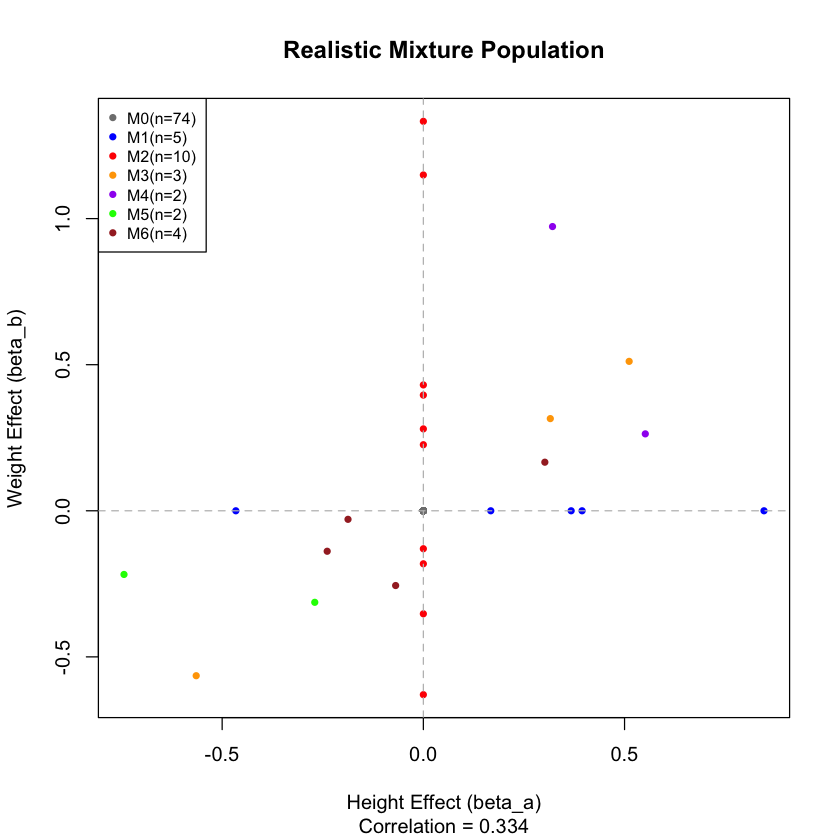

In [6]:
colors <- c("gray50", "blue", "red", "orange", "purple", "green", "brown")
names(colors) <- c("M0", "M1", "M2", "M3", "M4", "M5", "M6")
# Create colors for plotting based on component assignment
plot_colors <- colors[component_assignments]

# Plot the mixture population
plot(height_effects, weight_effects, 
     col = plot_colors, pch = 16, cex = 0.8,
     main = "Realistic Mixture Population", 
     xlab = "Height Effect (beta_a)", ylab = "Weight Effect (beta_b)",
     sub = paste("Correlation =", round(observed_correlation, 3)))

# Add reference lines
abline(h = 0, v = 0, lty = 2, col = "gray")

# Add legend
legend("topleft", 
       legend = paste(names(component_counts), "(n=", component_counts, ")", sep=""),
       col = colors[names(component_counts)], 
       pch = 16, cex = 0.8)

This is a mixture of the following components:

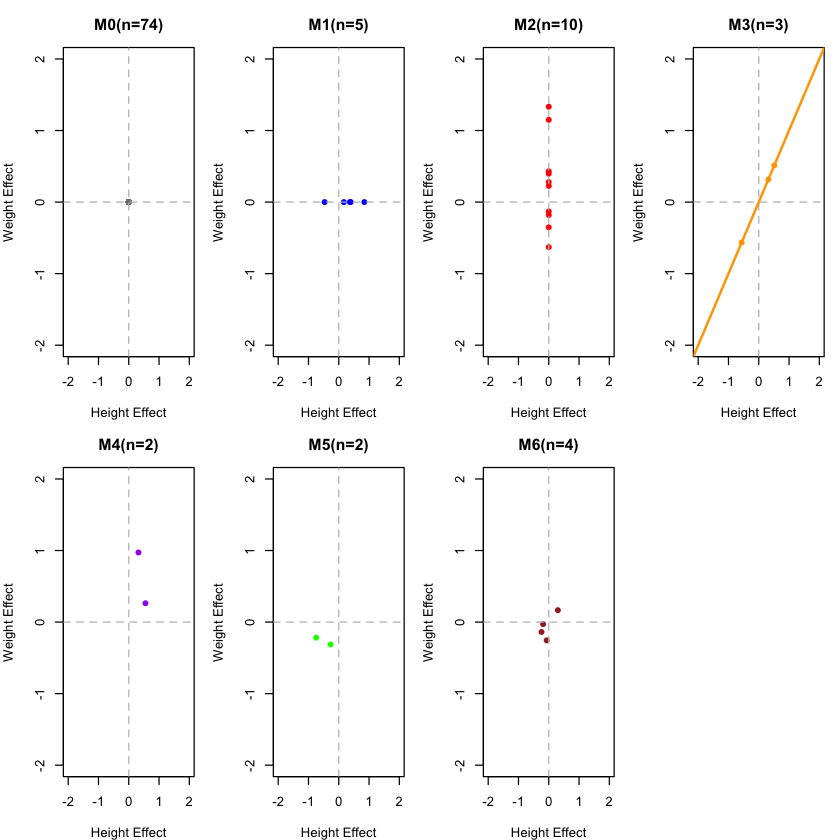

In [7]:
# Define colors for plotting
colors <- c("gray50", "blue", "red", "orange", "purple", "green", "brown")
names(colors) <- c("M0", "M1", "M2", "M3", "M4", "M5", "M6")

# Plot the actual component distributions from our real data
par(mfrow = c(2, 4), mar = c(4, 4, 3, 1))

for(comp in c("M0", "M1", "M2", "M3", "M4", "M5", "M6")) {
  # Extract variants belonging to this component
  idx <- which(component_assignments == comp)
  
  if(length(idx) > 0) {
    h_effects <- height_effects[idx]
    w_effects <- weight_effects[idx]
    
    plot(h_effects, w_effects, 
         main = paste(comp, "(n=", length(idx), ")", sep=""),
         xlab = "Height Effect", ylab = "Weight Effect",
         col = colors[comp], pch = 16, 
         xlim = c(-2, 2), ylim = c(-2, 2))
    abline(h = 0, v = 0, lty = 2, col = "gray")
    
    # Add correlation line for M3-M6
    if(comp == "M3") abline(0, 1, col = colors[comp], lwd = 2)
  } else {
    # Empty plot if no variants in this component
    plot(0, 0, type = "n", xlim = c(-2, 2), ylim = c(-2, 2),
         main = paste(comp, "(n=0)", sep=""),
         xlab = "Height Effect", ylab = "Weight Effect")
    abline(h = 0, v = 0, lty = 2, col = "gray")
  }
}

par(mfrow = c(1, 1))

### Simulating the Individual-Level Data

In [8]:
# Now let's simulate the complete genetic data
# Y = X * beta + error

# Generate genotype matrix X
# Each entry is 0, 1, or 2 (number of effect alleles)
# Assume minor allele frequency (MAF) = 0.3 for all variants
maf <- 0.3
X <- matrix(rbinom(N * M, size = 2, prob = maf), nrow = N, ncol = M)

cat("Genotype matrix X:\n")
cat("Dimensions:", dim(X), "(individuals x variants)\n")
cat("Range of values:", range(X), "\n")
cat("Mean genotype value:", round(mean(X), 2), "\n")

# Our effect sizes from the mixture model
beta_height <- height_effects
beta_weight <- weight_effects

cat("\nEffect sizes (beta):\n")
cat("Height effects range:", round(range(beta_height), 3), "\n")
cat("Weight effects range:", round(range(beta_weight), 3), "\n")

# Calculate genetic values: X %*% beta
genetic_height <- X %*% beta_height
genetic_weight <- X %*% beta_weight

cat("\nGenetic values (X * beta):\n")
cat("Height genetic values range:", round(range(genetic_height), 2), "\n")
cat("Weight genetic values range:", round(range(genetic_weight), 2), "\n")

# Add environmental noise to achieve desired heritability
# Heritability h^2 = Var(genetic) / Var(total)
# So Var(error) = Var(genetic) * (1 - h^2) / h^2

h2 <- 0.7  # 70% heritability
genetic_var_height <- var(genetic_height)
genetic_var_weight <- var(genetic_weight)

error_var_height <- genetic_var_height * (1 - h2) / h2
error_var_weight <- genetic_var_weight * (1 - h2) / h2

# Generate environmental errors
error_height <- rnorm(N, mean = 0, sd = sqrt(error_var_height))
error_weight <- rnorm(N, mean = 0, sd = sqrt(error_var_weight))

# Final phenotypes: Y = X*beta + epsilon
phenotype_height <- genetic_height + error_height
phenotype_weight <- genetic_weight + error_weight

cat("\nFinal phenotypes:\n")
cat("Height phenotypes range:", round(range(phenotype_height), 2), "\n")
cat("Weight phenotypes range:", round(range(phenotype_weight), 2), "\n")
cat("Phenotype correlation:", round(cor(phenotype_height, phenotype_weight), 3), "\n")

# Verify heritability
h2_height_check <- var(genetic_height) / var(phenotype_height)
h2_weight_check <- var(genetic_weight) / var(phenotype_weight)
cat("Achieved heritability - Height:", round(h2_height_check, 3), "\n")
cat("Achieved heritability - Weight:", round(h2_weight_check, 3), "\n")

Genotype matrix X:
Dimensions: 1000 100 (individuals x variants)
Range of values: 0 2 
Mean genotype value: 0.6 

Effect sizes (beta):
Height effects range: -0.744 0.847 
Weight effects range: -0.629 1.333 

Genetic values (X * beta):
Height genetic values range: -2.37 4.65 
Weight genetic values range: -2.49 9.18 



Final phenotypes:
Height phenotypes range: -3.57 5.34 
Weight phenotypes range: -4.72 9.68 
Phenotype correlation: 0.223 
Achieved heritability - Height: 0.668 
Achieved heritability - Weight: 0.712 


Mixture composition:


- Null variants: 74 %
- Pleiotropic variants: 11 %
- Effect correlation: 0.334 
- Phenotype correlation: 0.223 


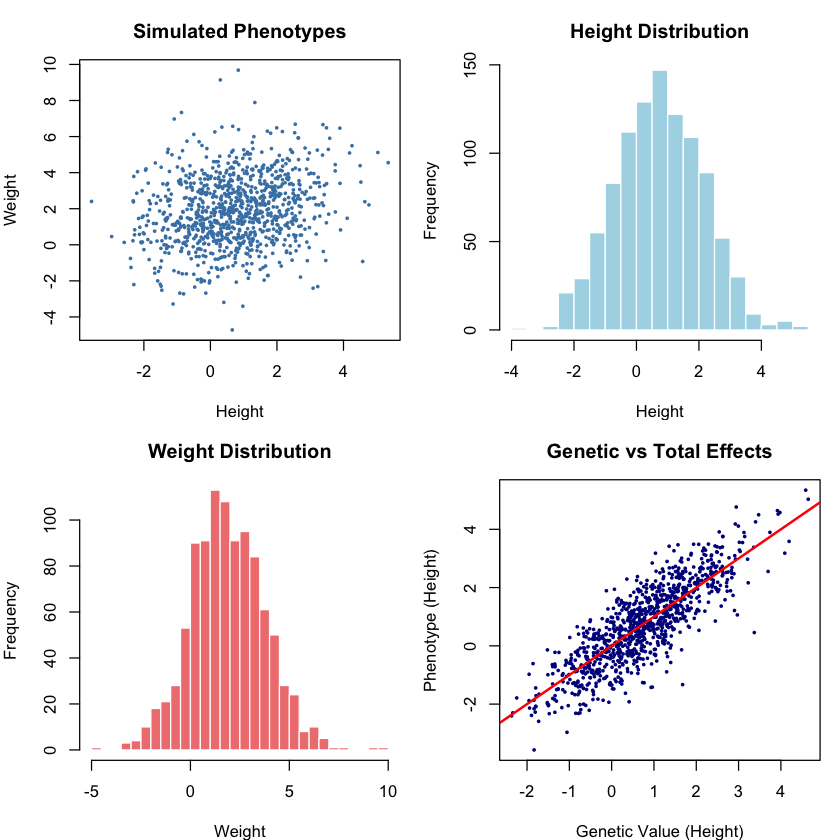

In [9]:
# Plot the final phenotypes
par(mfrow = c(2, 2), mar = c(4, 4, 3, 1))

# Phenotype scatter plot
plot(phenotype_height, phenotype_weight, pch = 16, cex = 0.5, col = "steelblue",
     main = "Simulated Phenotypes", 
     xlab = "Height", ylab = "Weight")

# Histograms of each trait
hist(phenotype_height, breaks = 30, col = "lightblue", border = "white",
     main = "Height Distribution", xlab = "Height", ylab = "Frequency")

hist(phenotype_weight, breaks = 30, col = "lightcoral", border = "white", 
     main = "Weight Distribution", xlab = "Weight", ylab = "Frequency")

# Genetic vs total effects
plot(genetic_height, phenotype_height, pch = 16, cex = 0.5, col = "darkblue",
     main = "Genetic vs Total Effects", 
     xlab = "Genetic Value (Height)", ylab = "Phenotype (Height)")
abline(0, 1, col = "red", lwd = 2)

par(mfrow = c(1, 1))

cat("Mixture composition:\n")
pleiotropy_rate <- sum(component_assignments %in% c("M3", "M4", "M5", "M6")) / M
null_rate <- sum(component_assignments == "M0") / M
cat("- Null variants:", round(null_rate*100, 1), "%\n")
cat("- Pleiotropic variants:", round(pleiotropy_rate*100, 1), "%\n")
cat("- Effect correlation:", round(cor(beta_height, beta_weight), 3), "\n")
cat("- Phenotype correlation:", round(cor(phenotype_height, phenotype_weight), 3), "\n")

## Bayesian Analysis with Fixed Mixture Prior

Now we'll demonstrate the key power of mixture models: analyzing variants with a flexible prior that allows each variant to belong to any component, rather than assuming all variants follow the same model.

For this multivariate example, we'll focus on analyzing height effects while using the mixture structure learned from the bivariate simulation.


In [10]:
# Use height phenotype for univariate analysis
Y <- phenotype_height

# Set up fixed mixture prior parameters based on the 7-component model
# These represent our prior knowledge about effect size distributions

# Fixed mixture weights (pi) - based on the original simulation weights
pi_prior <- c(0.70, 0.10, 0.10, 0.03, 0.02, 0.03, 0.02)
names(pi_prior) <- c("M0", "M1", "M2", "M3", "M4", "M5", "M6")

# Fixed component standard deviations (sigma) for height effects
# M0: null, M1: height-only, M2: weight-only (0 for height), M3-M6: pleiotropic
sigma_prior <- c(0.0,    # M0: null
                 0.5,    # M1: height effects
                 0.0,    # M2: weight-only (no height effect)
                 0.5,    # M3: pleiotropic
                 0.5,    # M4: pleiotropic
                 0.5,    # M5: pleiotropic
                 0.5)    # M6: pleiotropic
names(sigma_prior) <- c("M0", "M1", "M2", "M3", "M4", "M5", "M6")

cat("Fixed mixture prior for height effects:\n")
cat("Mixture weights (pi):", round(pi_prior, 3), "\n")
cat("Component sigmas (sigma):", sigma_prior, "\n")

Fixed mixture prior for height effects:
Mixture weights (pi): 0.7 0.1 0.1 0.03 0.02 0.03 0.02 
Component sigmas (sigma): 0 0.5 0 0.5 0.5 0.5 0.5 


## Computing Posterior Component Probabilities

For each variant, we compute the posterior probability of belonging to each component using Bayes' rule:


In [11]:
# Function to compute posterior component probabilities for univariate case
compute_posterior_probs_univariate <- function(X, Y, pi_mix, sigma_mix) {
  M <- ncol(X)
  N <- nrow(X)
  n_comp <- length(pi_mix)
  
  # Storage for posterior probabilities
  posterior_probs <- matrix(0, nrow = M, ncol = n_comp)
  colnames(posterior_probs) <- names(pi_mix)
  rownames(posterior_probs) <- paste("Variant", 1:M)
  
  # Estimate error variance from residual phenotypic variance
  sigma_e <- sd(Y) * 0.6  # Conservative estimate
  
  for(i in 1:M) {
    # Get genotype data for variant i
    Xi <- X[, i]
    Xi_centered <- Xi - mean(Xi)
    
    # Compute marginal likelihood under each component
    log_likelihoods <- numeric(n_comp)
    
    for(c in 1:n_comp) {
      sigma_beta <- sigma_mix[c]
      
      if(sigma_beta == 0) {
        # Null component: β = 0 exactly
        # Marginal likelihood: Y ~ N(μ, σ_e²)
        mu_null <- mean(Y)
        log_likelihoods[c] <- sum(dnorm(Y, mean = mu_null, sd = sigma_e, log = TRUE))
        
      } else {
        # Non-null component: β ~ N(0, σ_β²)
        # Use normal-normal conjugacy for marginal likelihood
        
        XtX <- sum(Xi_centered^2)
        XtY <- sum(Xi_centered * (Y - mean(Y)))
        
        if(XtX > 1e-10) {
          # Prior and likelihood precision
          tau_beta <- 1 / sigma_beta^2
          tau_e <- 1 / sigma_e^2
          
          # Posterior parameters
          post_var_beta <- 1 / (tau_beta + tau_e * XtX)
          post_mean_beta <- (tau_e * XtY) / (tau_beta + tau_e * XtX)
          
          # Log marginal likelihood (analytical)
          const_term <- -0.5 * N * log(2 * pi) - N * log(sigma_e)
          prior_term <- -0.5 * log(2 * pi * sigma_beta^2)
          post_term <- 0.5 * log(2 * pi * post_var_beta)
          
          # Quadratic form difference
          Y_centered <- Y - mean(Y)
          ss_total <- sum(Y_centered^2)
          ss_explained <- post_mean_beta^2 / post_var_beta
          
          quad_term <- -0.5 * tau_e * (ss_total - ss_explained)
          
          log_likelihoods[c] <- const_term + prior_term + post_term + quad_term
          
        } else {
          # No genetic variation
          log_likelihoods[c] <- -Inf
        }
      }
    }
    
    # Convert to posterior probabilities using Bayes' rule
    log_posteriors <- log(pi_mix) + log_likelihoods
    
    # Numerical stability
    max_log_post <- max(log_posteriors[is.finite(log_posteriors)])
    log_posteriors <- log_posteriors - max_log_post
    posteriors <- exp(log_posteriors)
    
    # Normalize
    posterior_probs[i, ] <- posteriors / sum(posteriors)
  }
  
  return(posterior_probs)
}

# Compute posterior probabilities
posterior_probs <- compute_posterior_probs_univariate(X, Y, pi_prior, sigma_prior)

cat("\nPosterior component probabilities (first 10 variants):\n")
print(round(posterior_probs[1:10, ], 3))


Posterior component probabilities (first 10 variants):
              M0    M1    M2    M3    M4    M5    M6
Variant 1  0.000 0.500 0.000 0.150 0.100 0.150 0.100
Variant 2  0.778 0.055 0.111 0.017 0.011 0.017 0.011
Variant 3  0.857 0.010 0.122 0.003 0.002 0.003 0.002
Variant 4  0.852 0.013 0.122 0.004 0.003 0.004 0.003
Variant 5  0.845 0.017 0.121 0.005 0.003 0.005 0.003
Variant 6  0.852 0.013 0.122 0.004 0.003 0.004 0.003
Variant 7  0.811 0.037 0.116 0.011 0.007 0.011 0.007
Variant 8  0.852 0.013 0.122 0.004 0.003 0.004 0.003
Variant 9  0.855 0.011 0.122 0.003 0.002 0.003 0.002
Variant 10 0.850 0.014 0.121 0.004 0.003 0.004 0.003


## Posterior Effect Size Estimates

In [12]:
# Compute posterior effect size estimates using mixture posterior
posterior_effects <- numeric(M)
posterior_vars <- numeric(M)

sigma_e <- sd(Y) * 0.6

for(i in 1:M) {
  Xi <- X[, i] - mean(X[, i])
  XtX <- sum(Xi^2)
  XtY <- sum(Xi * (Y - mean(Y)))
  
  # Mixture posterior for effect size
  mixture_mean <- 0
  mixture_second_moment <- 0
  
  for(c in 1:7) {
    prob_c <- posterior_probs[i, c]
    sigma_c <- sigma_prior[c]
    
    if(sigma_c == 0) {
      # Null component contributes zero
      comp_mean <- 0
      comp_second_moment <- 0
    } else {
      # Non-null component posterior
      tau_beta <- 1 / sigma_c^2
      tau_e <- 1 / sigma_e^2
      
      if(XtX > 1e-10) {
        post_var <- 1 / (tau_beta + tau_e * XtX)
        post_mean <- (tau_e * XtY) / (tau_beta + tau_e * XtX)
      } else {
        post_var <- sigma_c^2
        post_mean <- 0
      }
      
      comp_mean <- post_mean
      comp_second_moment <- post_var + post_mean^2
    }
    
    # Mixture moments
    mixture_mean <- mixture_mean + prob_c * comp_mean
    mixture_second_moment <- mixture_second_moment + prob_c * comp_second_moment
  }
  
  mixture_var <- mixture_second_moment - mixture_mean^2
  
  posterior_effects[i] <- mixture_mean
  posterior_vars[i] <- mixture_var
}

# Results for first 5 variants
results_table <- data.frame(
  Variant = 1:5,
  True_Effect = round(beta_height[1:5], 3),
  Posterior_Mean = round(posterior_effects[1:5], 3),
  Posterior_SD = round(sqrt(posterior_vars[1:5]), 3)
)

cat("\nPosterior Effect Size Estimates (first 5 variants):\n")
print(results_table)


Posterior Effect Size Estimates (first 5 variants):
  Variant True_Effect Posterior_Mean Posterior_SD
1       1      -0.239         -0.313        0.040
2       2       0.000         -0.007        0.024
3       3       0.000          0.000        0.006
4       4       0.000         -0.001        0.008
5       5       0.000         -0.001        0.010


## Updated Mixture Weights


Comparison of mixture weights:
                       M0    M1    M2    M3    M4    M5    M6
Prior               0.700 0.100 0.100 0.030 0.020 0.030 0.020
Empirical_Posterior 0.602 0.156 0.086 0.047 0.031 0.047 0.031


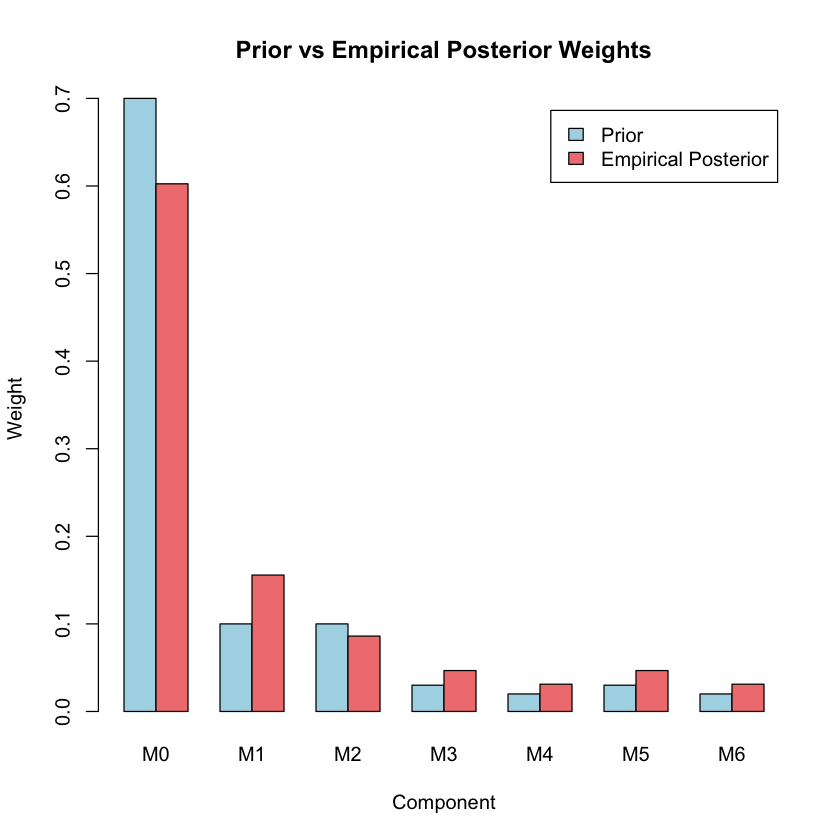

In [19]:
# Compare prior vs posterior mixture weights
empirical_weights <- colMeans(posterior_probs)

cat("Comparison of mixture weights:\n")
weight_comparison <- rbind(
  Prior = pi_prior,
  Empirical_Posterior = empirical_weights
)
print(round(weight_comparison, 3))

# Plot weight comparison
barplot(weight_comparison, beside = TRUE, 
        col = c("lightblue", "lightcoral"),
        main = "Prior vs Empirical Posterior Weights",
        xlab = "Component", ylab = "Weight",
        legend.text = c("Prior", "Empirical Posterior"))

# Supplementary

## Graphical Summary


Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




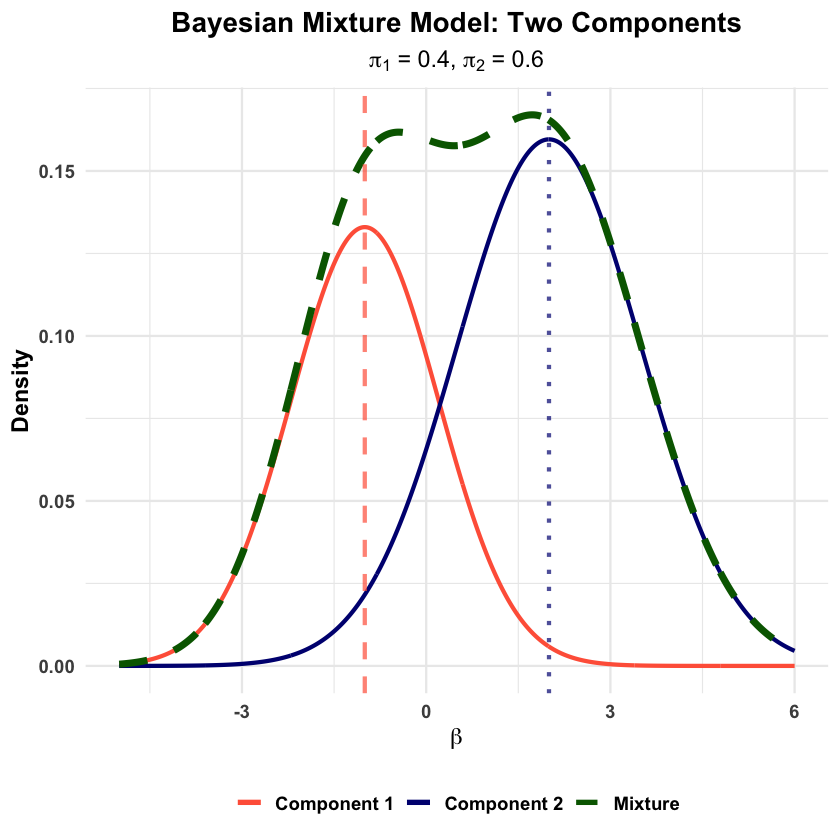

In [38]:
library(ggplot2)
library(dplyr)

# Set parameters for two components
mu1 <- -1      # Mean of component 1
mu2 <- 2       # Mean of component 2
sigma1 <- 1.2  # SD of component 1
sigma2 <- 1.5  # SD of component 2
pi1 <- 0.4     # Weight of component 1
pi2 <- 0.6     # Weight of component 2

# Create data for plotting
x <- seq(-5, 6, length.out = 1000)

# Individual component densities
component1 <- pi1 * dnorm(x, mu1, sigma1)
component2 <- pi2 * dnorm(x, mu2, sigma2)

# Mixture density
mixture <- component1 + component2

# Create data frame for plotting
plot_data <- data.frame(
  x = rep(x, 3),
  density = c(component1, component2, mixture),
  distribution = rep(c("Component 1", "Component 2", "Mixture"), each = length(x))
)

# Create the plot
p <- ggplot(plot_data, aes(x = x, y = density, color = distribution, linetype = distribution)) +
  geom_line(aes(linewidth = distribution)) +
  scale_linewidth_manual(values = c("Component 1" = 1.2, 
                                   "Component 2" = 1.2, 
                                   "Mixture" = 2.0)) +
  scale_color_manual(values = c("Component 1" = "tomato", 
                               "Component 2" = "#000080", 
                               "Mixture" = "darkgreen")) +
  scale_linetype_manual(values = c("Component 1" = "solid", 
                                  "Component 2" = "solid", 
                                  "Mixture" = "dashed")) +
  labs(
    title = "Bayesian Mixture Model: Two Components",
    subtitle = expression(paste(pi[1], " = 0.4, ", pi[2], " = 0.6")),
    x = expression(beta),
    y = "Density",
    color = "Distribution",
    linetype = "Distribution"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5),
    axis.title.y = element_text(face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold"),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_blank(),
    legend.text = element_text(face = "bold"),
    legend.position = "bottom"
  ) +
  guides(color = guide_legend(override.aes = list(linewidth = 1.5)),
         linewidth = "none")

# Add vertical lines for component means and labels
p <- p + 
  geom_vline(xintercept = mu1, color = "tomato", linetype = "dashed", alpha = 0.7, linewidth = 1.2) +
  geom_vline(xintercept = mu2, color = "#000080", linetype = "dotted", alpha = 0.7, linewidth = 1.2) 

# Display the plot
print(p)

# Save the plot
ggsave("./cartoons/Bayesian_mixture_model.png", plot = p,
       width = 10, height = 6, 
       bg = "transparent",
       dpi = 300)